In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from WelfareMeasures import *
from functions_njit import tax_rate_fct
from bernoulli_distribution import Bernoulli
from help_functions_non_njit import *
from graph_format import *
# load local model file and initialize model class
from model import ModelClass
from scipy.optimize import minimize

# Load original model

In [2]:
model = ModelClass() # set a few number of periods.

par = model.par
sol = model.sol
sim = model.sim
par.opt_tol = 1e-6
par.opt_maxiter = 1000

%time model.solve(do_print=False)
%time model.simulate()

CPU times: total: 12min 57s
Wall time: 3min 17s
CPU times: total: 42.7 s
Wall time: 27 s


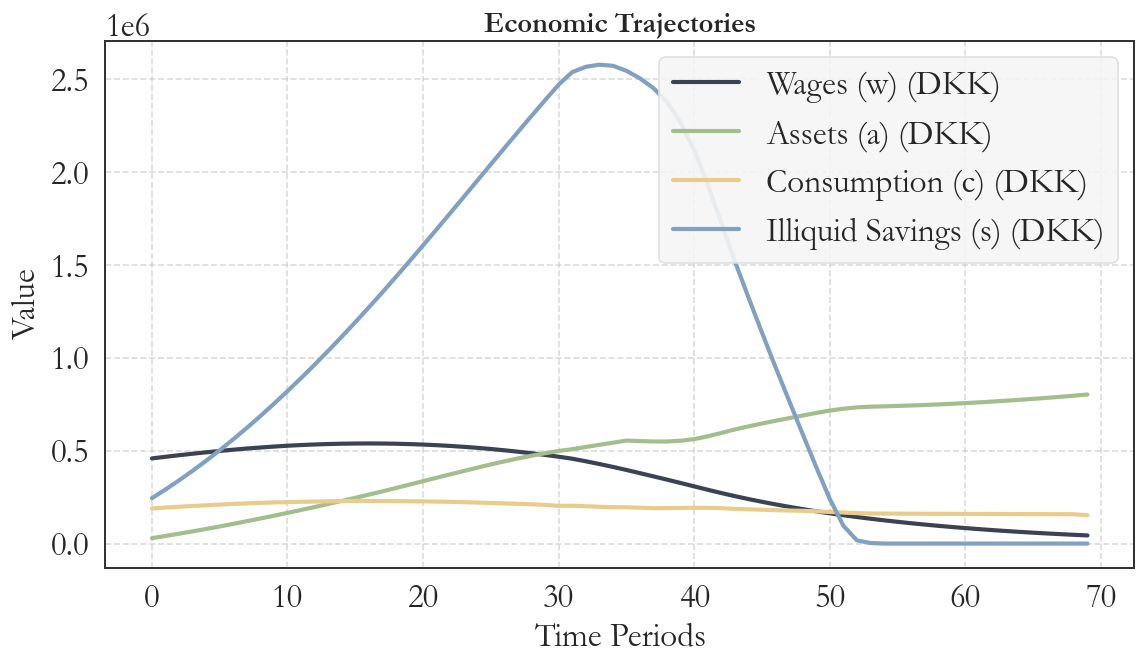

In [3]:
time = np.arange(par.T)
data_dict_basic = {
    "Wages (w)": {"data": np.mean(model.sim.w[:], axis=0), "unit": "DKK"},
    "Assets (a)": {"data": np.mean(model.sim.a[:], axis=0), "unit": "DKK"},
    "Consumption (c)": {"data": np.mean(model.sim.c[:], axis=0), "unit": "DKK"},
    "Illiquid Savings (s)": {"data": np.mean(model.sim.s[:], axis=0), "unit": "DKK"},
}

plot_simulation_one_graph(data_dict_basic, time, title="Economic Trajectories")

# Counter factual

In [4]:
# Change parameters and re-solve
theta = [31, 36] # Jeg har slukket for opdatering af first_retirement, hvor den opdateres herinde. Early forskydes, hvis first forskydes
theta_names = ['first_retirement','retirement_age']

og_model, new_model =  make_new_model(model, theta, theta_names, do_print = False)


# Labor supply

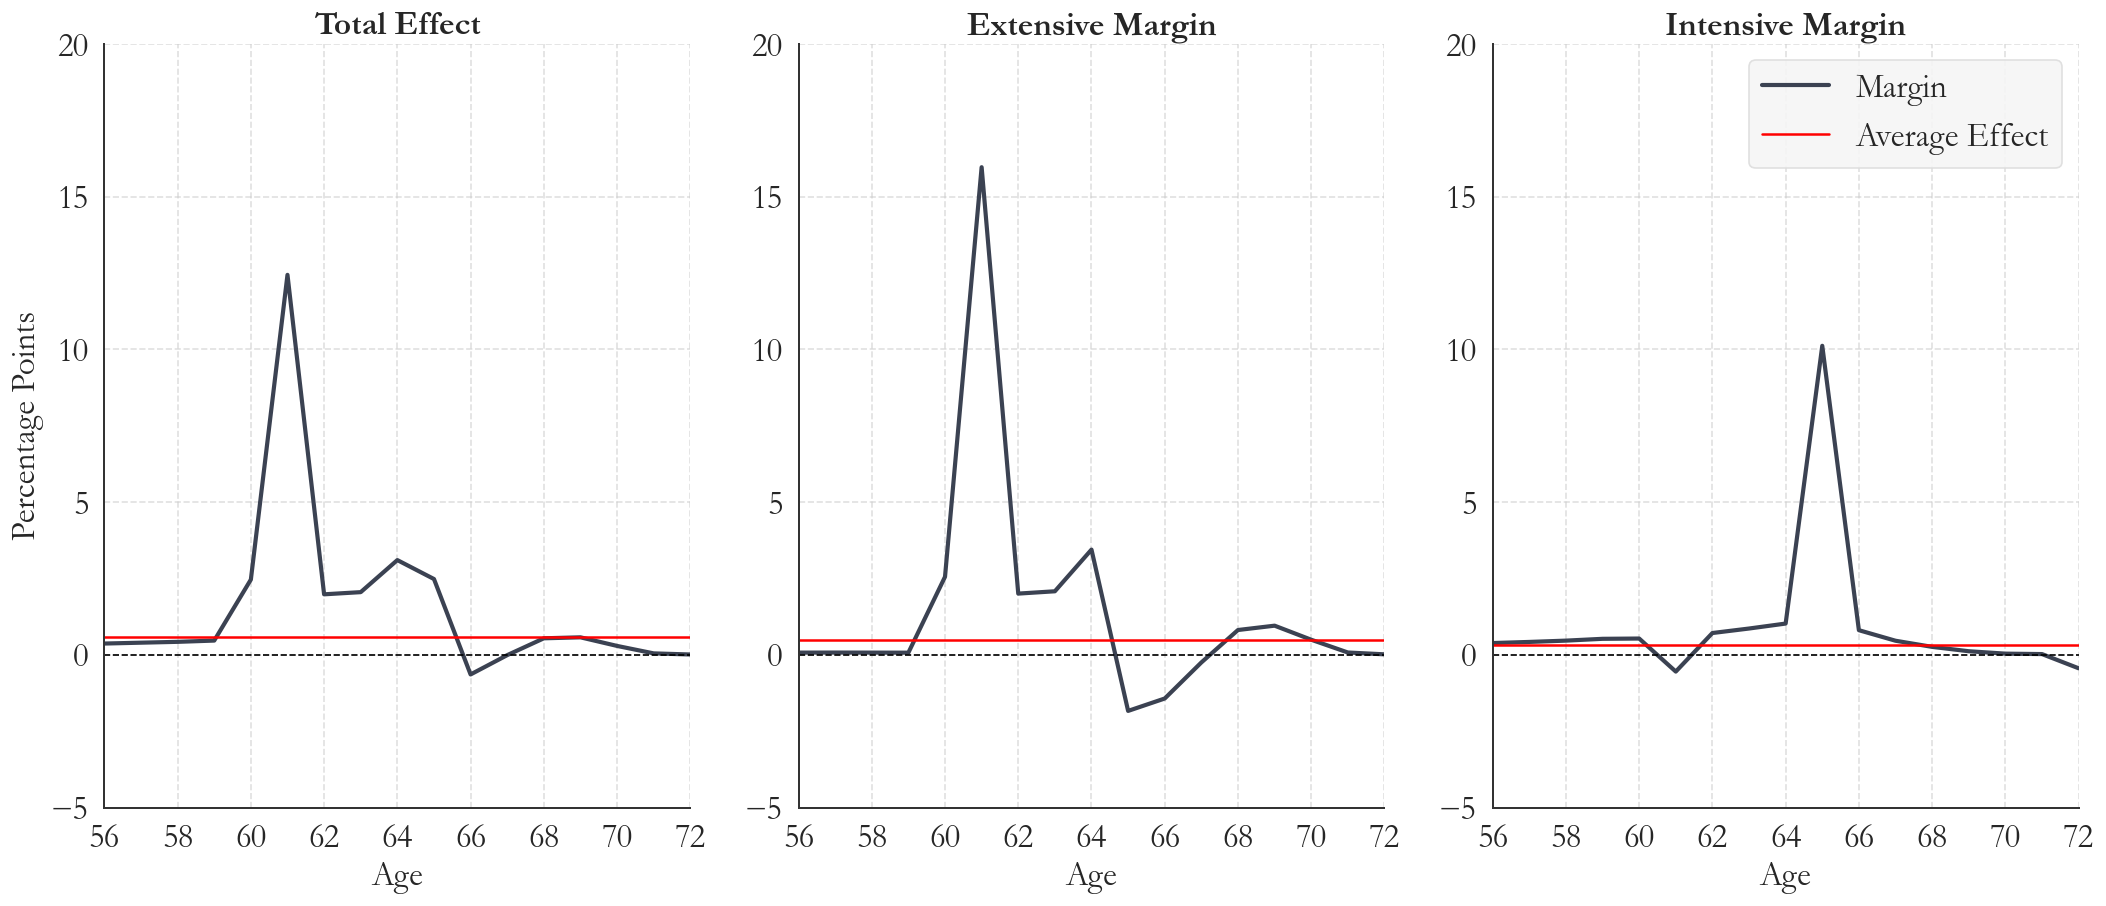

In [91]:
# Compare models 
# consumption_eq = find_consumption_equivalence(og_model, new_model, do_print= True, the_method = 'brentq')
intensive_margin, extensive_margin, total_margin, total_per_person, intensive_margin_age, extensive_margin_age, total_margin_age  = labor_elasticity(og_model, new_model)


plot_labor_margins_by_age(
    intensive_age=intensive_margin_age,
    extensive_age=extensive_margin_age,
    total_age=total_margin_age,
    avg_intensive=intensive_margin,
    avg_extensive=extensive_margin,
    avg_total=total_margin,
    age_start=par.start_age,
    # title_prefix="Labor Supply — ",
    save_title="CF_r_age_66_everything_labor.png",
    ylim_total=(-5, 20),
    ylim_extensive=(-5, 20),
    ylim_intensive=(-5, 20)
)

In [92]:
total_margin

0.005672825878225431

In [83]:
pi_cum = np.cumprod(par.pi)

total_margin_og = np.mean(pi_cum[:og_model.par.last_retirement] * og_model.sim.h[:, :og_model.par.last_retirement])
total_margin_new = np.mean(pi_cum[:og_model.par.last_retirement] * new_model.sim.h[:, :og_model.par.last_retirement])
test = (total_margin_new-total_margin_og)/total_margin_og

test

0.01229747791759336

# Consumption Equivalence - distribution

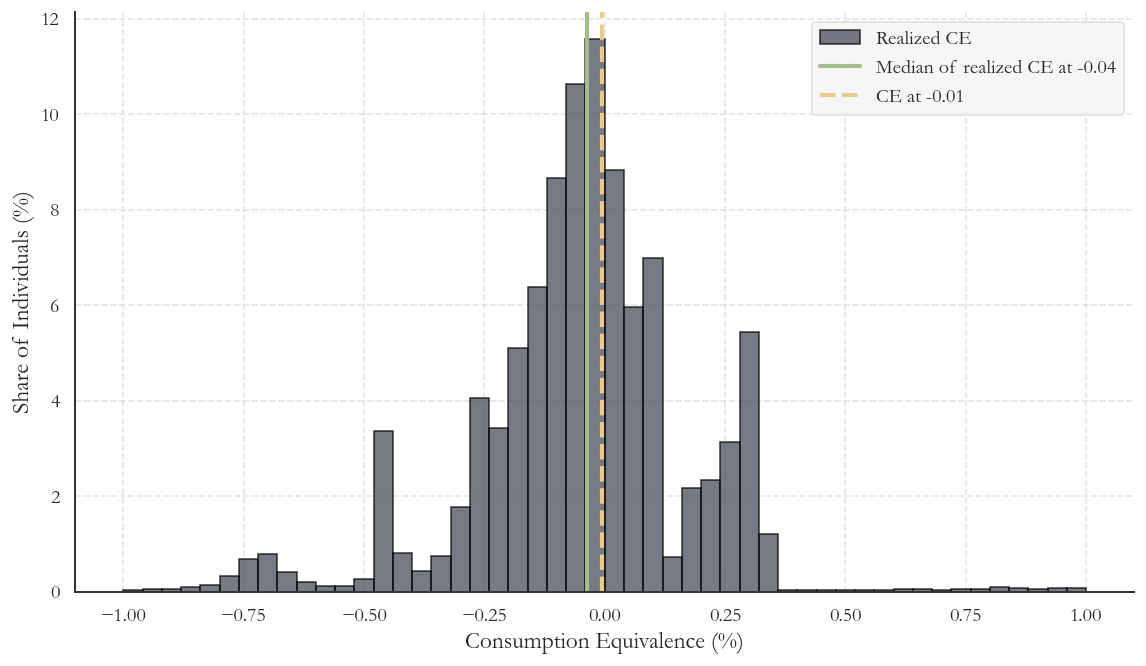

In [ ]:
con_eq = analytical_consumption_equivalence_indi(og_model, new_model)
plot_event_histogram(con_eq[:]*100, 'Consumption Equivalence (%)', 
                    #  'Consumption Equivalence Distribution for a 30-year-old',
                         label1="Realized CE",
                         figsize=(10, 6), bins=50, range=(-1,1), median_val=np.median(con_eq)*100, mean_val =np.mean(con_eq)*100, save_title='CF_r_age_66_everything_CE_dist')

In [ ]:
np.mean(con_eq*100< -0.25)

np.float64(0.13956)

In [ ]:
np.mean(con_eq*100>0.25)

np.float64(0.11952)

# Unofficial retirement age

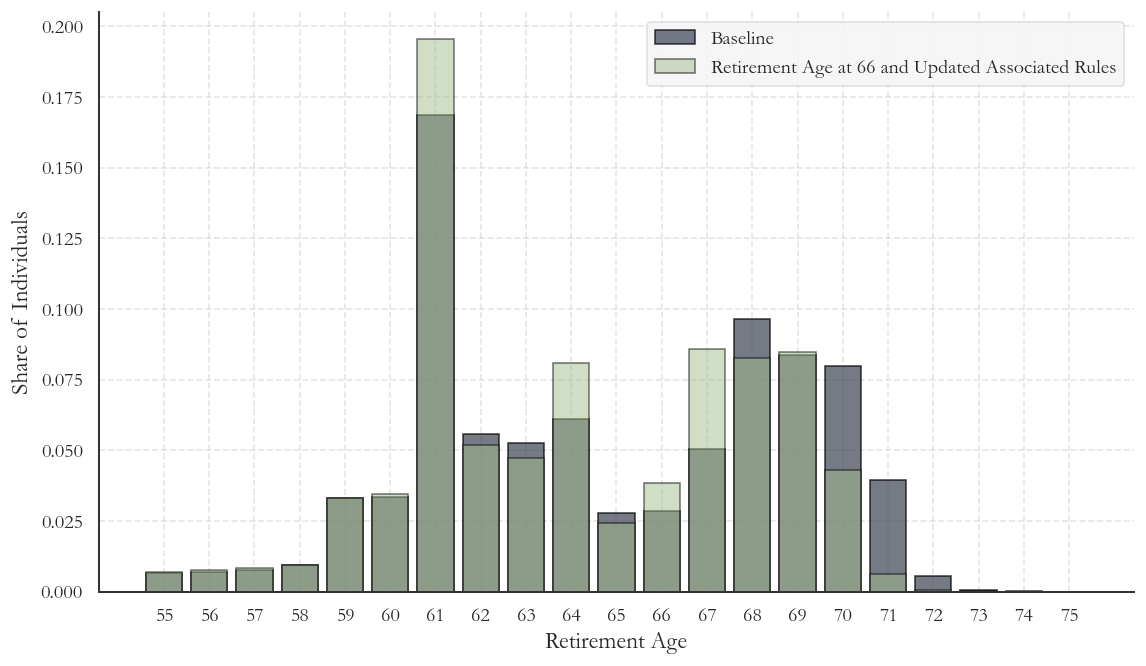

In [ ]:
# 1. Find last time ex == 1 for each individual
last_working = np.full(og_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(og_model.sim.ex.shape[0]):
    working = np.where(og_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working.size > 0:
        last_working[i] = working[-1] +1  # last time they worked (take last index)

# 1. Find last time ex == 1 for each individual
last_working_new = np.full(new_model.sim.ex.shape[0], np.nan)  # initialize

for i in range(new_model.sim.ex.shape[0]):
    working_new = np.where(new_model.sim.ex[i, :] == 1)[0]  # find where ex=1
    if working_new.size > 0:
        last_working_new[i] = working_new[-1]  # last time they worked (take last index)

plot_event_bar_series(
    values1=last_working,
    values2=last_working_new,
    xlabel="Retirement Age",
    # title="Timing of Unofficial Retirement",
    label1="Baseline",
    label2="Retirement Age at 66 and Updated Associated Rules",
    bins=np.arange(25, 46),
    save_title="CF_r_age_66_everything_un_ret.png",
)


# Official retirement age

In [ ]:
def official_retirement(model):
    first_retirement = np.full(model.sim.e.shape[0], np.nan)  # initialize

    for i in range(model.sim.e.shape[0]):
        retired = np.where(model.sim.e[i, :] == 2)[0]  # find where e=2
        if retired.size > 0:
            first_retirement[i] = retired[0]  # first time they retire
        if model.sim.efter_init[i]:
            if len(model.sim.ex[i,:]) - np.argmax(model.sim.ex[i,:][::-1] == 1)< first_retirement[i]:
                first_retirement[i] = len(model.sim.ex[i,:]) - np.argmax(model.sim.ex[i,:][::-1] == 1)

    return first_retirement

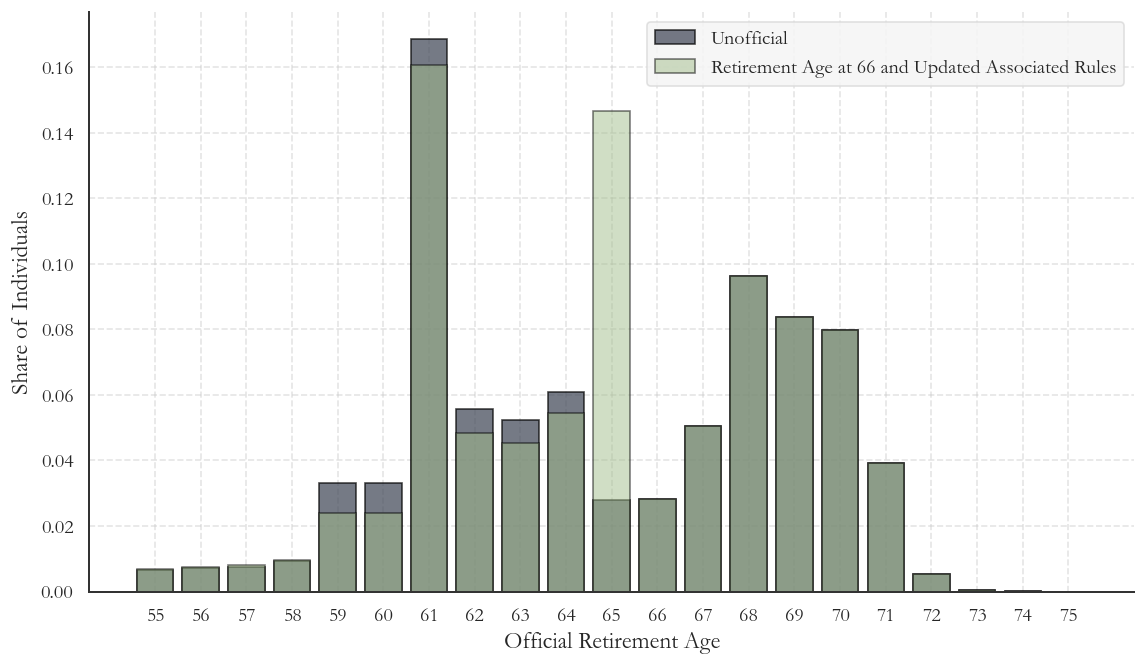

In [ ]:
first_retirement_og = official_retirement(og_model)
first_retirement_new = official_retirement(new_model)

plot_event_bar_series(
    values1=last_working,
    values2=first_retirement_og,
    xlabel="Official Retirement Age",
    # title="Timing of Official Retirement",
    label1="Unofficial",
    label2="Retirement Age at 66 and Updated Associated Rules",
    bins=np.arange(25, 46),
    save_title="CF_r_age_66_everything_of_ret.png",
)


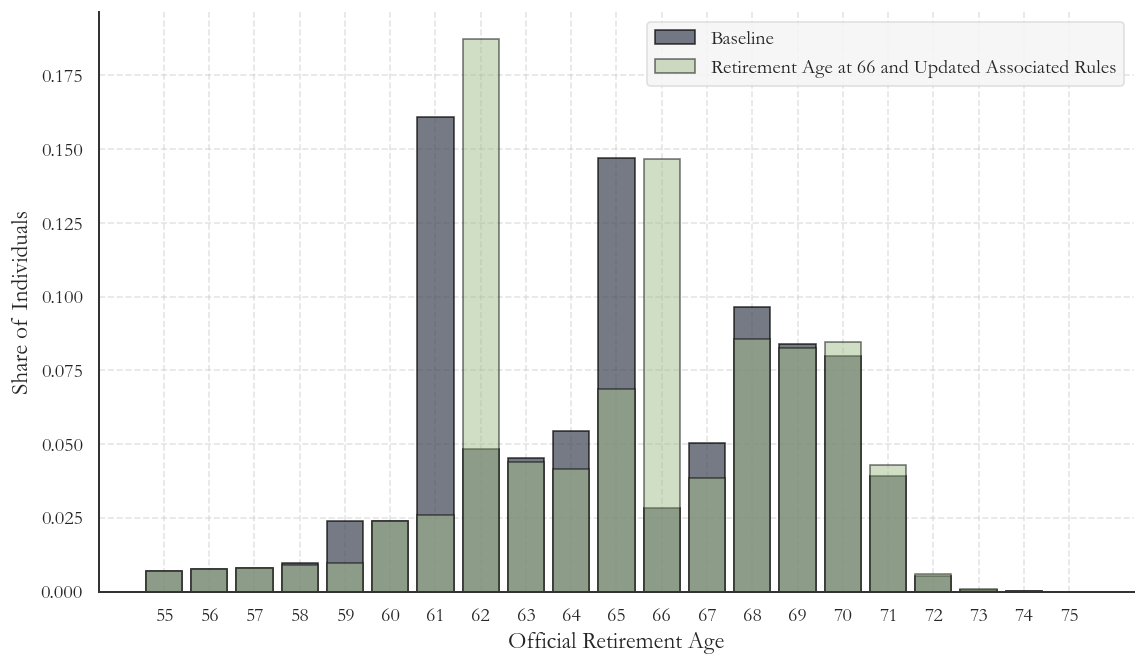

In [ ]:
first_retirement_og = official_retirement(og_model)
first_retirement_new = official_retirement(new_model)

plot_event_bar_series(
    values1=first_retirement_og,
    values2=first_retirement_new,
    xlabel="Official Retirement Age",
    # title="Timing of Official Retirement",
    label1="Baseline",
    label2="Retirement Age at 66 and Updated Associated Rules",
    bins=np.arange(25, 46),
    save_title="CF_r_age_66_everything_of_ret.png",
)


# Voluntary retirement age

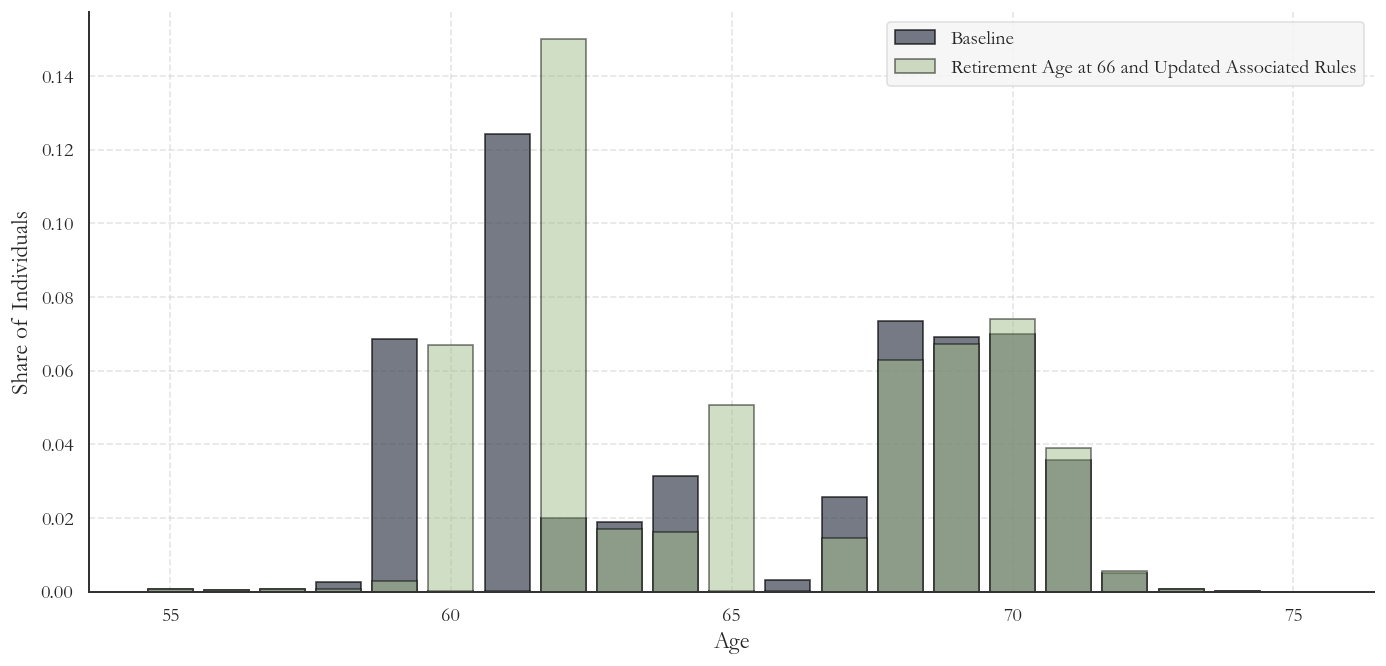

In [ ]:
og_ret_counts = np.sum(og_model.sim.ret_flag[:, :], axis=0)
new_ret_counts = np.sum(new_model.sim.ret_flag[:, :], axis=0)
plot_bar_series_comparison(
    og_ret_counts,
    new_ret_counts,
    label1="Baseline",
    label2="Retirement Age at 66 and Updated Associated Rules",
    # title="Voluntary Retirements per Period",
    xlabel="Age",
    normalize=True,
    t_start=25, 
    t_end=46,
    save_title="CF_r_age_66_everything_vol_ret.png",
)


# Consumption Replacement Rate

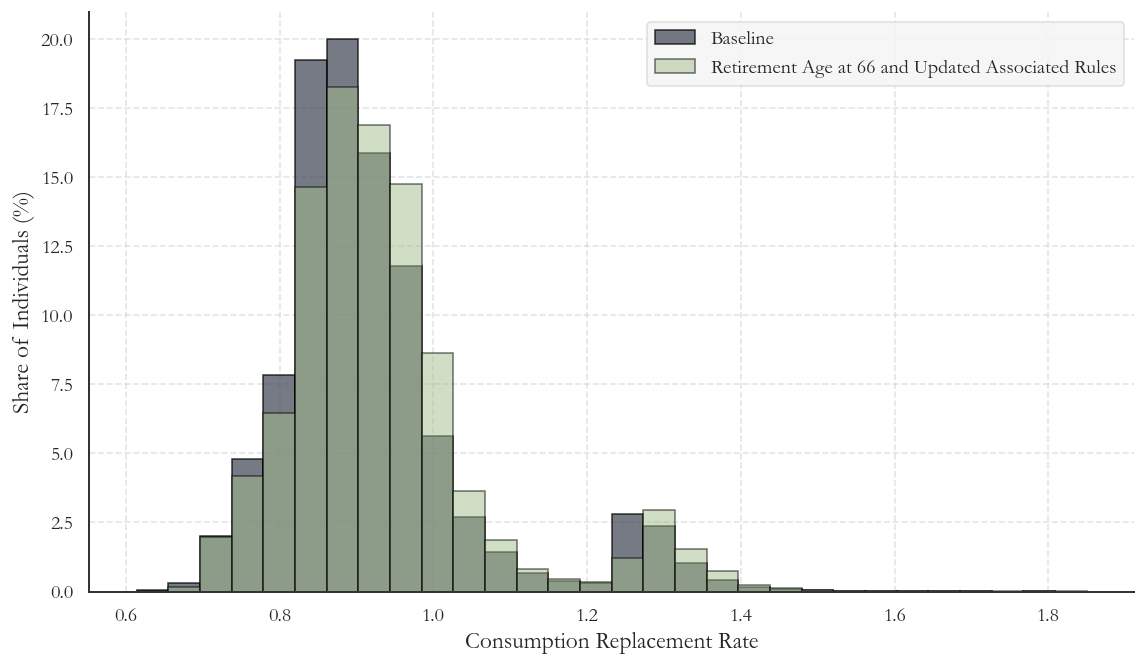

In [ ]:
plot_event_histogram(
    values1=consumption_replacement_rate_fct(og_model),
    values2=consumption_replacement_rate_fct(new_model),
    xlabel="Consumption Replacement Rate",
    # title="Consumption Replacement Rate",
    label1="Baseline",
    label2="Retirement Age at 66 and Updated Associated Rules",
    bins=30,
    save_title="CF_r_age_66_everything_CR.png",
)

# Replacement Rate

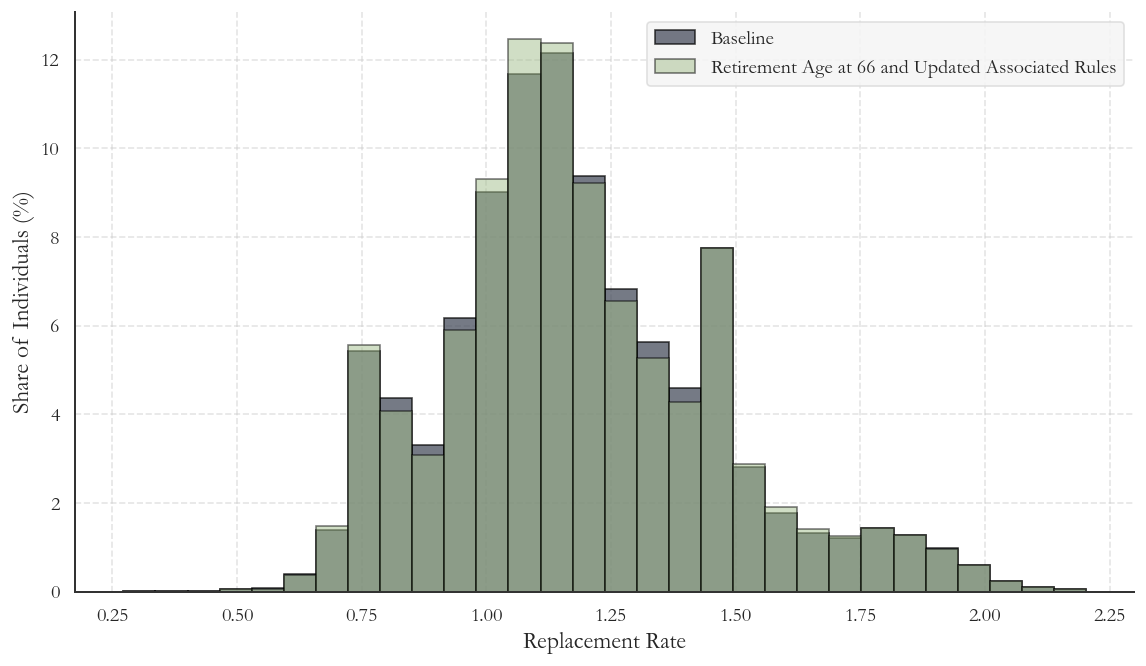

In [ ]:
plot_event_histogram(
    values1=replacement_rate_fct(og_model),
    values2=replacement_rate_fct(new_model),
    xlabel="Replacement Rate",
    # title="Replacement Rate",
    label1="Baseline",
    label2="Retirement Age at 66 and Updated Associated Rules",
    bins=30,
    save_title="CF_r_age_66_everything_RR.png"
)


# Consumption equivalence over Age

In [96]:
EV_age_new

[-22.130238953922817,
 -21.99828427298677,
 -21.868749480229656,
 -21.738251693354425,
 -21.60617249374757,
 -21.472021840843038,
 -21.335435954828196,
 -21.196268981165666,
 -21.054315674185336,
 -20.909307632097605,
 -20.760682529918416,
 -20.608307829406346,
 -20.451896498587196,
 -20.291059930109917,
 -20.12556648522701,
 -19.955278686458783,
 -19.779687887874783,
 -19.598331813445206,
 -19.41103169197221,
 -19.217529879923518,
 -19.017743499065627,
 -18.811465393621532,
 -18.59850092395292,
 -18.378503348939105,
 -18.15131653922488,
 -17.91686561843957,
 -17.675220336587493,
 -17.426338008074403,
 -17.17024179889815,
 -16.906960010571424,
 -16.636339343075683,
 -16.357426468404253,
 -16.0715086366935,
 -15.795770289082233,
 -15.516595415536164,
 -15.234284429257212,
 -14.952144536172918,
 -14.672235423699561,
 -14.389510328116202,
 -14.107029276069179,
 -13.825719060528547,
 -13.546583390883335,
 -13.268373976646203,
 -12.98884820182645,
 -12.708912255142542,
 -12.42579787087526,


In [98]:
EV_age_og, EV_weight_og = ev_model(og_model)

In [101]:
np.array(EV_age_new) - np.array(EV_age_og)

array([-3.77580331e-04, -2.94497085e-04, -2.13661410e-04, -1.33574902e-04,
       -5.79161109e-05,  1.94322525e-05,  9.97478252e-05,  1.78815837e-04,
        2.52997298e-04,  3.41527007e-04,  4.28529706e-04,  5.08544359e-04,
        5.95295182e-04,  6.92939013e-04,  7.95729827e-04,  9.11203438e-04,
        9.85767142e-04,  1.06603117e-03,  1.16221136e-03,  1.26447921e-03,
        1.36683175e-03,  1.45234085e-03,  1.50006057e-03,  1.57667025e-03,
        1.63689087e-03,  1.72219089e-03,  1.83417635e-03,  1.97930100e-03,
        2.09701036e-03,  2.16300517e-03,  2.23463991e-03,  2.39032584e-03,
        1.75357024e-02,  1.91047779e-02,  2.08560533e-02,  2.38639130e-02,
        2.94415186e-02,  2.87044135e-02,  2.85788954e-02,  2.90351222e-02,
        2.95865298e-02,  2.99327844e-02,  2.90124670e-02,  2.84047911e-02,
        2.51154727e-02,  2.43187229e-02,  2.34723566e-02,  2.21977983e-02,
        2.25384045e-02,  2.28264169e-02,  2.27827232e-02,  2.24024837e-02,
        2.18957662e-02,  

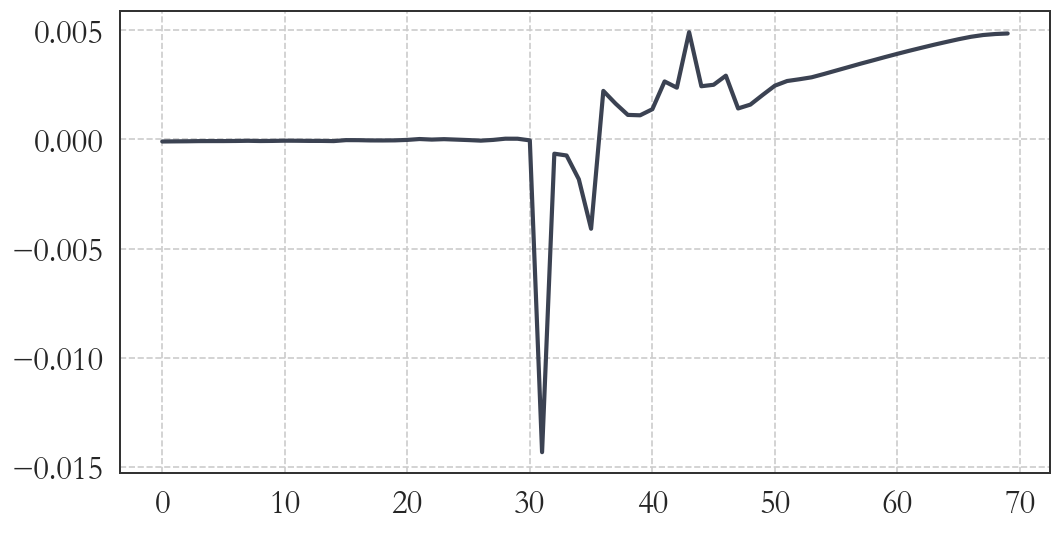

In [186]:
t = 35

test_list = []

for t in range(70):
    model = og_model

    h = model.sim.h
    k = model.sim.k
    c = model.sim.c
    a = model.sim.a

    bq_old = bequest(model, a[:, t])
    util_old = utility_work(model, h[:,t], k[:,t], t)
    util_c_old = utility_consumption(model, c[:, t])

    model = new_model

    h = model.sim.h
    k = model.sim.k
    c = model.sim.c
    a = model.sim.a

    bq_new = bequest(model, a[:, t])
    util_new = utility_work(model, h[:,t], k[:,t], t)
    util_c_new = utility_consumption(model, c[:, t])

    test_list.append(np.mean(util_new) - np.mean(util_old) + np.mean(util_c_new) - np.mean(util_c_old) + (1-par.pi[t]) * (np.mean(bq_new) - np.mean(bq_old)))

plt.plot(test_list)

# print(np.mean(util_new) - np.mean(util_old))
# print(np.mean(util_c_new) - np.mean(util_c_old))
# print(np.mean(bq_new) - np.mean(bq_old))

# print(np.mean(util_new) - np.mean(util_old) + np.mean(util_c_new) - np.mean(util_c_old) + np.mean(bq_new) - np.mean(bq_old))


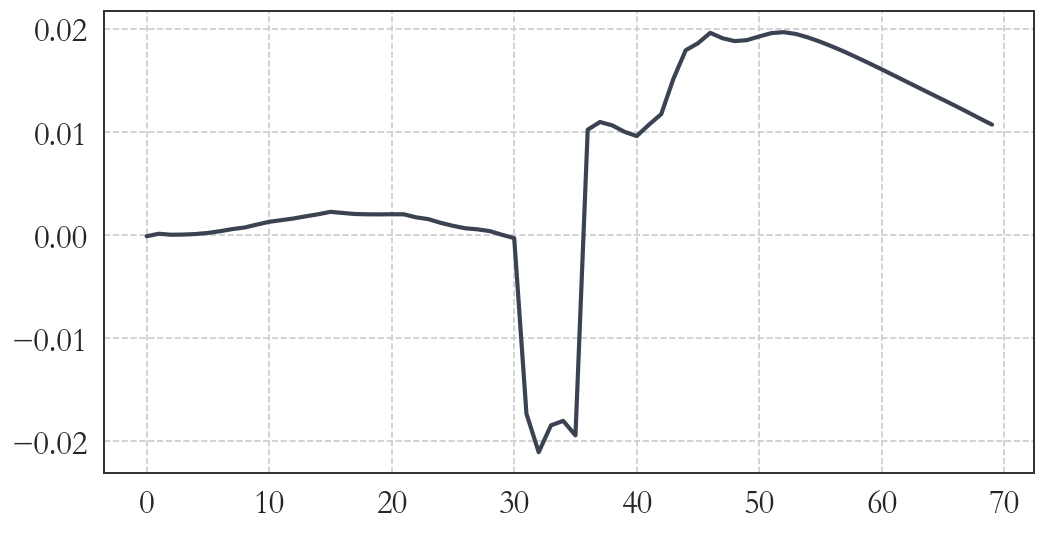

In [161]:
EV_age_old, EV_weight_old, tc_old = ev_model(og_model)
EV_age_new, EV_weight_new, tc_new = ev_model(new_model)

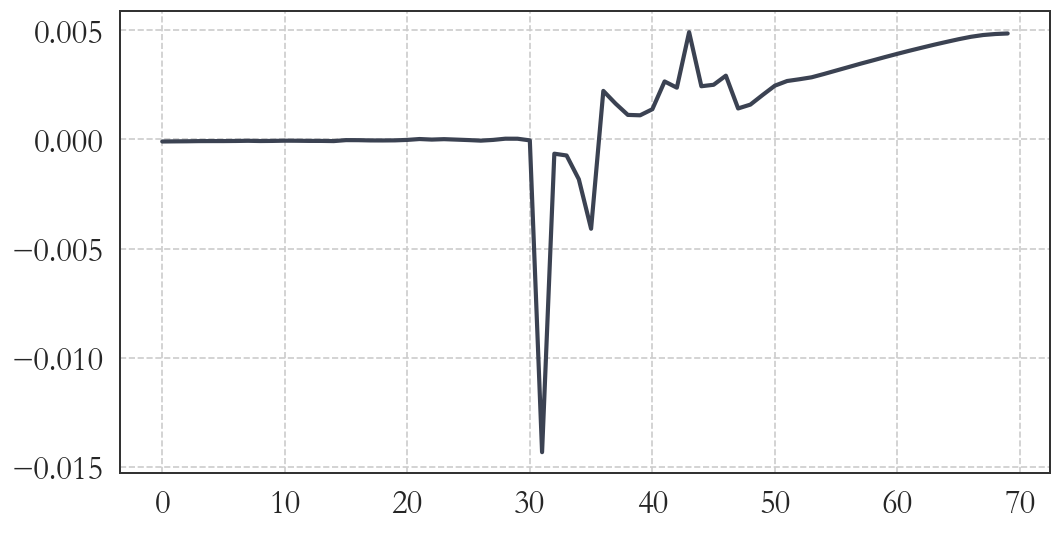

In [164]:
plt.plot(np.array(tc_new) - np.array(tc_old))

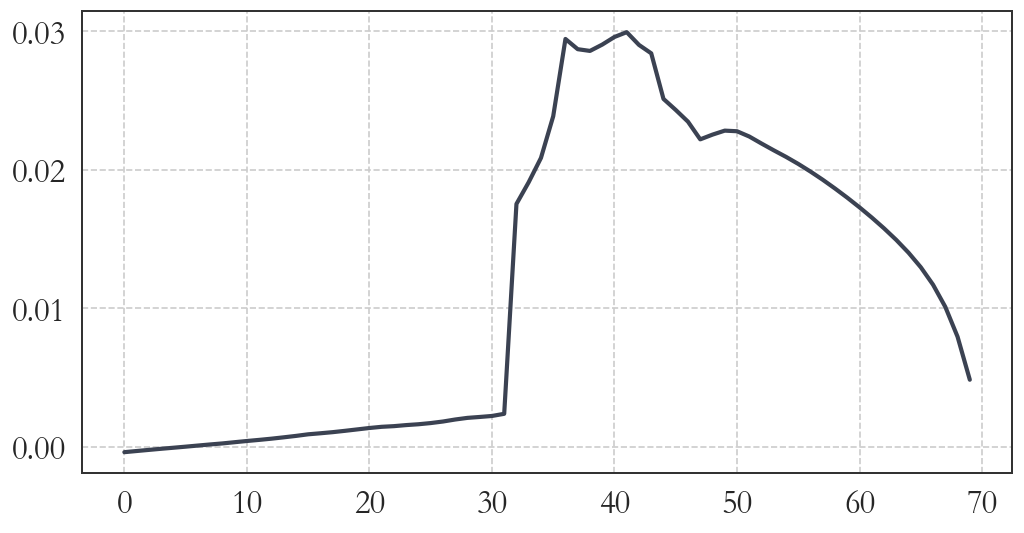

In [160]:
plt.plot(np.array(EV_age_new) - np.array(EV_age_old))

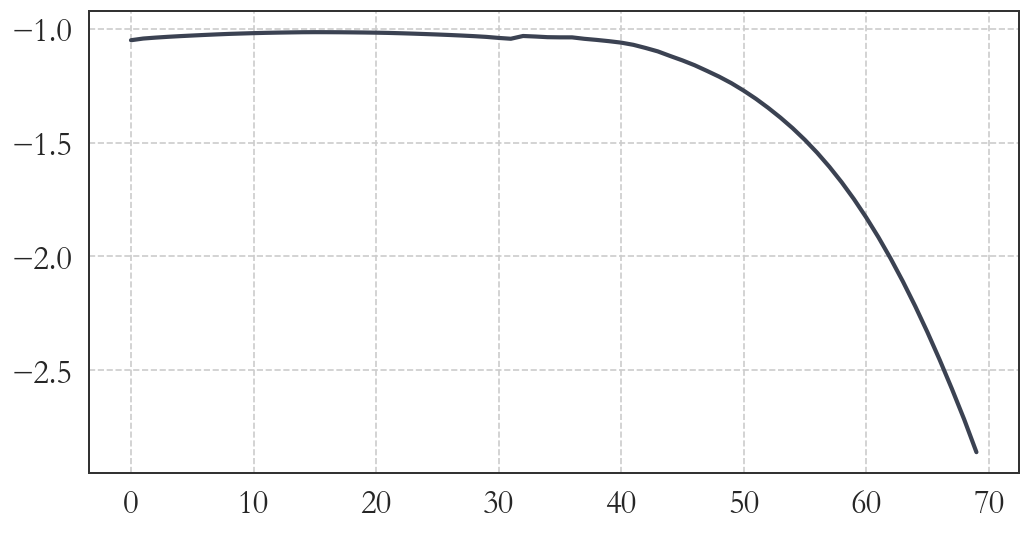

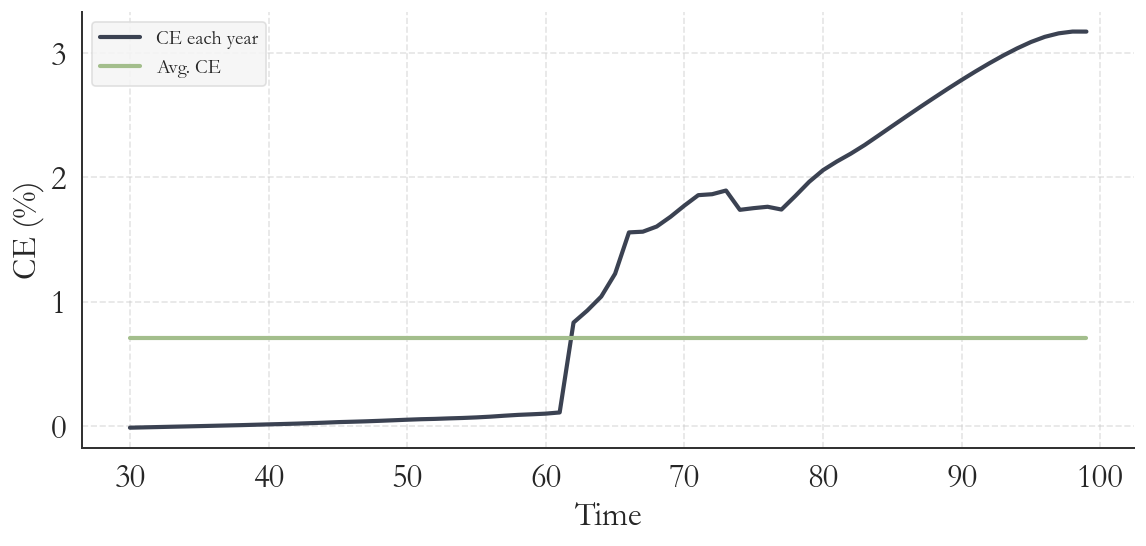

In [150]:
EV_age_new, EV_weight_new = ev_model(new_model)
phi_age, phi_avg = analytical_age_phi(og_model, EV_age_new)
plot_single_line_with_reference(
    line_data=phi_age,
    reference_value=phi_avg,
    label_line="CE each year",
    label_ref="Avg. CE",
    ylabel="CE (%)",
    scale=100,
    save_title="CF_r_age_66_everything_CE_age.png"
)

# Comparison of means

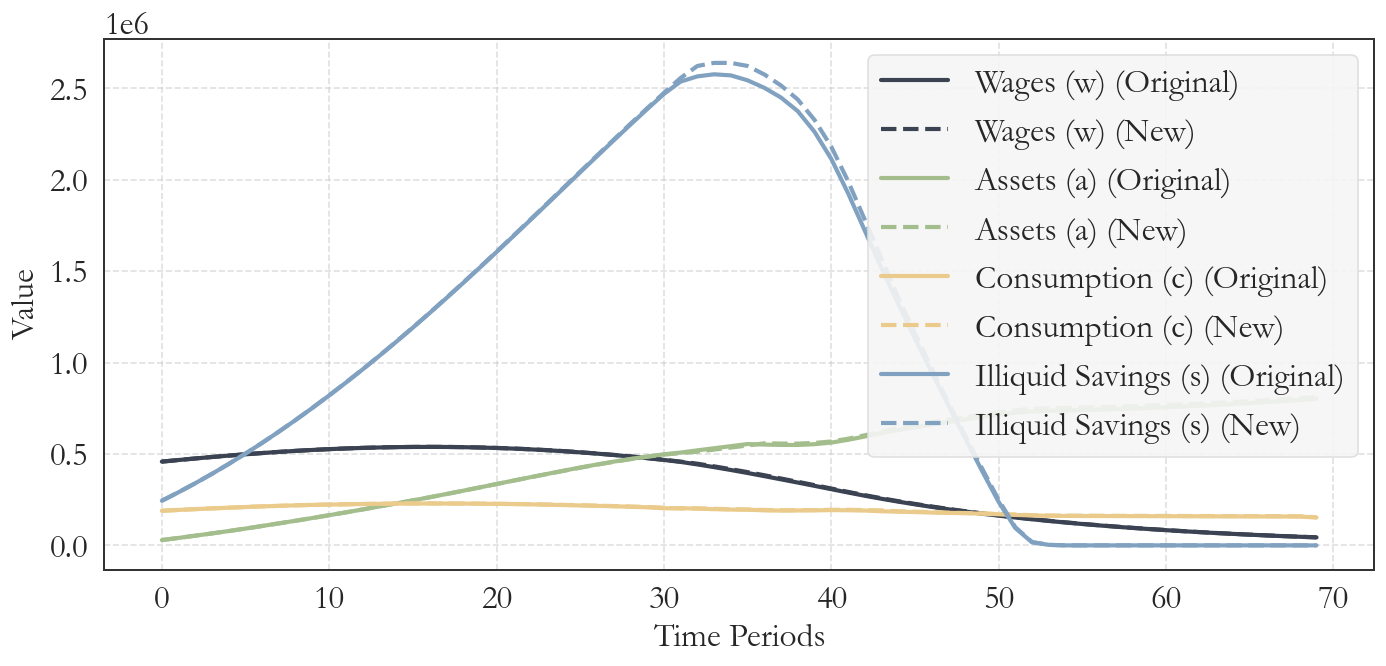

In [ ]:
time = np.arange(par.T)

# Data for selected summary variables
summary_vars = ["Wages (w)", "Assets (a)", "Consumption (c)", "Illiquid Savings (s)"]
simulated_data_new = {
    "Wages (w)": np.mean(new_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(new_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(new_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(new_model.sim.s[:], axis=0),
}
simulated_data_og = {
    "Wages (w)": np.mean(og_model.sim.w[:], axis=0),
    "Assets (a)": np.mean(og_model.sim.a[:], axis=0),
    "Consumption (c)": np.mean(og_model.sim.c[:], axis=0),
    "Illiquid Savings (s)": np.mean(og_model.sim.s[:], axis=0),
}

plot_comparison_single_panel(simulated_data_og, simulated_data_new, summary_vars, time, save_title="CF_r_age_66_everything_means.png")
